# Convolutional Autoencoder Training for L1Trigger

## Packages

In [6]:
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import roc_curve, auc

import keras_tuner
from keras_tuner import Hyperband

import joblib

## Read input files

All input files are already sorted in Calo regions (i, j) ~ (18, 14)<br>
Where i = 0 -> 17 corresponds to GCT_Phi = 0 -> 17<br>
Where j = 0 -> 13 corresponds to RCT_Eta = 4 -> 17

Keep this ordering as is when feeding into neural nets. Also keep this in mind when generating/preparing new samples.

### Backgrounds

In [7]:
ZeroBias = np.concatenate((h5py.File('bkg/ZeroBias_0.h5', 'r')['CaloRegions'][()],
                           h5py.File('bkg/ZeroBias_1.h5', 'r')['CaloRegions'][()],
                           h5py.File('bkg/ZeroBias_2.h5', 'r')['CaloRegions'][()]))
ZeroBias = ZeroBias.astype(dtype = 'float32').reshape(ZeroBias.shape[0], 18, 14, 1)
print(ZeroBias.shape)

#QCD = np.concatenate((h5py.File('bkg/110X/QCD_0.h5', 'r')['CaloRegions'][()],
#                      h5py.File('bkg/110X/QCD_1.h5', 'r')['CaloRegions'][()],
#                      h5py.File('bkg/110X/QCD_2.h5', 'r')['CaloRegions'][()]))
QCD = h5py.File('bkg/110X/QCD_0.h5', 'r')['CaloRegions'][()]
QCD = QCD.astype(dtype = 'float32').reshape(QCD.shape[0], 18, 14, 1)
print(QCD.shape)
QCD = QCD[:100000, :, :, :]
print(QCD.shape)

SingleNu_E10 = np.concatenate((h5py.File('bkg/120X/SingleNeutrino_E-10_0.h5', 'r')['CaloRegions'][()],
                                     h5py.File('bkg/120X/SingleNeutrino_E-10_1.h5', 'r')['CaloRegions'][()],
                                     h5py.File('bkg/120X/SingleNeutrino_E-10_2.h5', 'r')['CaloRegions'][()]))
SingleNu_E10 = SingleNu_E10.astype(dtype = 'float32').reshape(SingleNu_E10.shape[0], 18, 14, 1)
print(SingleNu_E10.shape)
SingleNu_E10 = SingleNu_E10[:100000, :, :, :]
print(SingleNu_E10.shape)

SingleNu_Pt2To20 = np.concatenate((h5py.File('bkg/120X/SingleNeutrino_Pt-2To20_0.h5', 'r')['CaloRegions'][()],
                                         h5py.File('bkg/120X/SingleNeutrino_Pt-2To20_1.h5', 'r')['CaloRegions'][()],
                                         h5py.File('bkg/120X/SingleNeutrino_Pt-2To20_2.h5', 'r')['CaloRegions'][()]))
SingleNu_Pt2To20 = SingleNu_Pt2To20.astype(dtype = 'float32').reshape(SingleNu_Pt2To20.shape[0], 18, 14, 1)
print(SingleNu_Pt2To20.shape)
SingleNu_Pt2To20 = SingleNu_Pt2To20[:100000, :, :, :]
print(SingleNu_Pt2To20.shape)

(315766, 18, 14, 1)
(2400000, 18, 14, 1)
(100000, 18, 14, 1)
(976000, 18, 14, 1)
(100000, 18, 14, 1)
(995000, 18, 14, 1)
(100000, 18, 14, 1)


### Signals

In [8]:
signal_files = []
signal_files.append('sig/110X/GluGluToHHTo4B_node_SM_TuneCP5_14TeV.h5')#i=0
signal_files.append('sig/110X/HTo2LongLivedTo4mu_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-12_CTau-900mm_TuneCP5_14TeV.h5')
signal_files.append('sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-25_CTau-1500mm_TuneCP5_14TeV.h5')
signal_files.append('sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/110X/VBFHToTauTau_M125_TuneCUETP8M1_14TeV.h5')
signal_files.append('sig/110X/VBF_HH_CV_1_C2V_1_C3_1_TuneCP5_PSweights_14TeV.h5')
signal_files.append('sig/110X/VBF_HToInvisible_M125_TuneCUETP8M1_14TeV.h5')
signal_files.append('sig/110X/VectorZPrimeToQQ_M100_pT300_TuneCP5_14TeV.h5')
signal_files.append('sig/110X/VectorZPrimeToQQ_M200_pT300_TuneCP5_14TeV.h5')
signal_files.append('sig/110X/VectorZPrimeToQQ_M50_pT300_TuneCP5_14TeV.h5')#i=10
signal_files.append('sig/110X/ZprimeToZH_MZprime1000_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5')
signal_files.append('sig/110X/ZprimeToZH_MZprime600_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5')
signal_files.append('sig/110X/ZprimeToZH_MZprime800_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/GluGluHToTauTau_M-125_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/GluGluToHHTo4B_node_cHHH1_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/GluGluToHHTo4B_node_cHHH5_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-1000_MFF-450_CTau-100000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-12_CTau-9000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-12_CTau-900mm_TuneCP5_14TeV.h5')#i=20
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-25_CTau-15000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-25_CTau-1500mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-50_CTau-30000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-250_MFF-120_CTau-10000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-250_MFF-120_CTau-1000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-250_MFF-60_CTau-1000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-10000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-1000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-500mm_TuneCP5_14TeV.h5')#i=30
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-10000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-1000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-500mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4mu_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4mu_MH-125_MFF-12_CTau-900mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4mu_MH-125_MFF-25_CTau-1500mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4mu_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-1200_TuneCP5_13TeV.h5')
signal_files.append('sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-120_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-350_TuneCP5_14TeV.h5')#i=40
signal_files.append('sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-600_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/TprimeBToTH_M-650_LH_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/VBFHHTo4B_CV_1_C2V_2_C3_1_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/VBFHToInvisible_M125_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/VBFHToTauTau_M125_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/VectorZPrimeGammaToQQGamma_M-10_GPt-75_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/VectorZPrimeToQQ_M-100_Pt-300_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/VectorZPrimeToQQ_M-200_Pt-300_TuneCP5_14TeV.h5')#i=48

signals = []
for i in range(len(signal_files)):
    signals.append(h5py.File(signal_files[i], 'r')['CaloRegions'][()].astype(dtype = 'float32'))
    signals[i] = signals[i].reshape(signals[i].shape[0], 18, 14, 1)
    print(str(i) + ': ' + str(signals[i].shape))

0: (50000, 18, 14, 1)
1: (39851, 18, 14, 1)
2: (40000, 18, 14, 1)
3: (13000, 18, 14, 1)
4: (40000, 18, 14, 1)
5: (300000, 18, 14, 1)
6: (30000, 18, 14, 1)
7: (291000, 18, 14, 1)
8: (1854, 18, 14, 1)
9: (38023, 18, 14, 1)
10: (6285, 18, 14, 1)
11: (50000, 18, 14, 1)
12: (50000, 18, 14, 1)
13: (50000, 18, 14, 1)
14: (300000, 18, 14, 1)
15: (100000, 18, 14, 1)
16: (100000, 18, 14, 1)
17: (39987, 18, 14, 1)
18: (39985, 18, 14, 1)
19: (35302, 18, 14, 1)
20: (31255, 18, 14, 1)
21: (33454, 18, 14, 1)
22: (40000, 18, 14, 1)
23: (34144, 18, 14, 1)
24: (34533, 18, 14, 1)
25: (29768, 18, 14, 1)
26: (18805, 18, 14, 1)
27: (39229, 18, 14, 1)
28: (30055, 18, 14, 1)
29: (38482, 18, 14, 1)
30: (32293, 18, 14, 1)
31: (40000, 18, 14, 1)
32: (33214, 18, 14, 1)
33: (29860, 18, 14, 1)
34: (1420, 18, 14, 1)
35: (37639, 18, 14, 1)
36: (27488, 18, 14, 1)
37: (32150, 18, 14, 1)
38: (41783, 18, 14, 1)
39: (500000, 18, 14, 1)
40: (178468, 18, 14, 1)
41: (36472, 18, 14, 1)
42: (98476, 18, 14, 1)
43: (100000, 18, 

## Create overlaid samples (ZB + signals) for test

In [9]:
#Overlay signal events on top of ZB before testing
#Simple addition tower by tower: overlaid signal = ZB + signal
#ZB is chosen at random for each signal event before overlaying them
np.random.seed(0)
signals_zb = []
for i in range(len(signals)):
    signals_zb.append(np.empty((signals[i].shape[0], 18, 14, 1)))
    ZB_random_event = np.random.randint(low = 0, high = ZeroBias.shape[0], size = signals[i].shape[0])
    for j in range(signals[i].shape[0]):
        signals_zb[i][j, :, :, 0] = ZeroBias[ZB_random_event[j], :, :, 0] + signals[i][j, :, :, 0]

In [10]:
#Overlay QCD events on top of ZB
np.random.seed(0)
QCD_zb = np.empty((QCD.shape[0], 18, 14, 1))
ZB_random_event = np.random.randint(low = 0, high = ZeroBias.shape[0], size = QCD.shape[0])
for i in range(QCD.shape[0]):
    QCD_zb[i, :, :, 0] = ZeroBias[ZB_random_event[i], :, :, 0] + QCD[i, :, :, 0]

In [11]:
#Overlay neutrino events on top of ZB
np.random.seed(0)
SingleNu_E10_zb = np.empty((SingleNu_E10.shape[0], 18, 14, 1))
ZB_random_event = np.random.randint(low = 0, high = ZeroBias.shape[0], size = SingleNu_E10.shape[0])
for i in range(SingleNu_E10.shape[0]):
    SingleNu_E10_zb[i, :, :, 0] = ZeroBias[ZB_random_event[i], :, :, 0] + SingleNu_E10[i, :, :, 0]
    
SingleNu_Pt2To20_zb = np.empty((SingleNu_Pt2To20.shape[0], 18, 14, 1))
ZB_random_event = np.random.randint(low = 0, high = ZeroBias.shape[0], size = SingleNu_Pt2To20.shape[0])
for i in range(SingleNu_Pt2To20.shape[0]):
    SingleNu_Pt2To20_zb[i, :, :, 0] = ZeroBias[ZB_random_event[i], :, :, 0] + SingleNu_Pt2To20[i, :, :, 0]

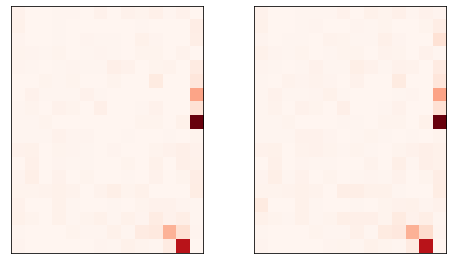

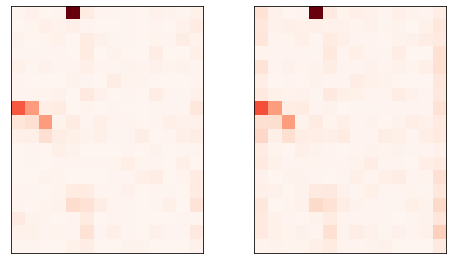

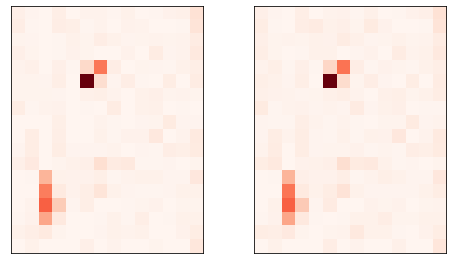

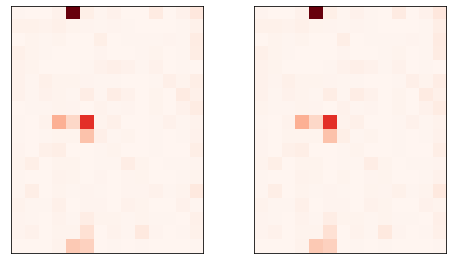

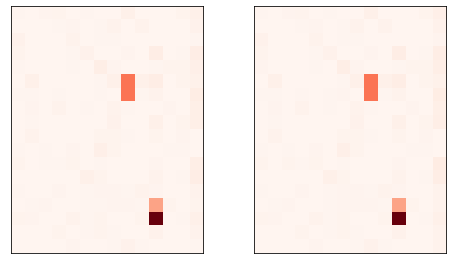

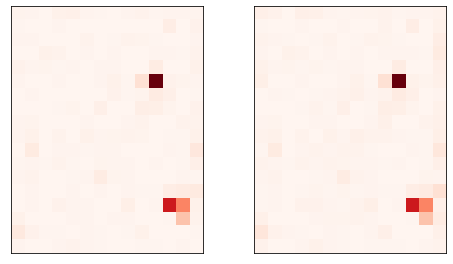

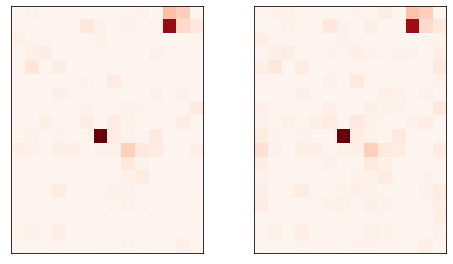

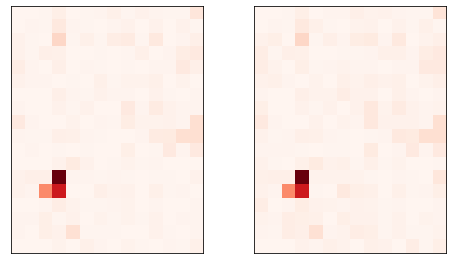

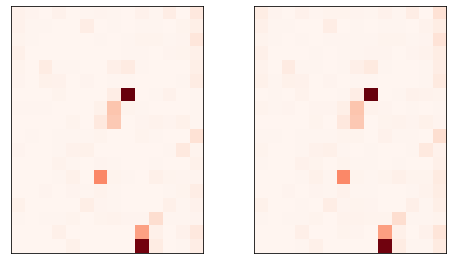

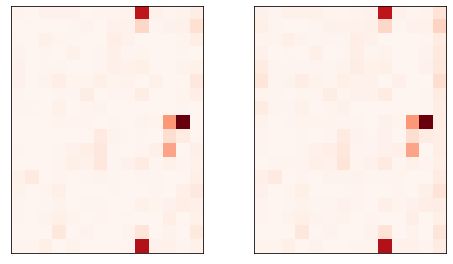

In [12]:
#Plot and compare signals before and after the overlay
n = 12
for i in range(110, 120):
    plt.figure(figsize = (8, 10))
    ax = plt.subplot(2, 2, 1)
    plt.imshow(signals[n][i,:,:,0].reshape(18, 14), cmap = 'Reds')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 2, 2)
    plt.imshow(signals_zb[n][i,:,:,0].reshape(18, 14), cmap = 'Reds')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    plt.show()

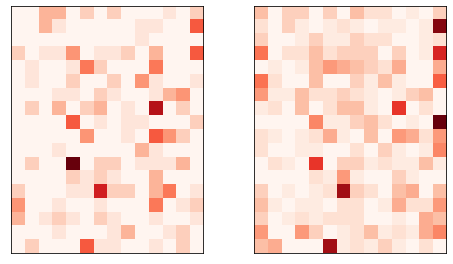

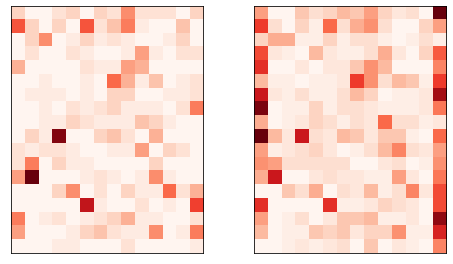

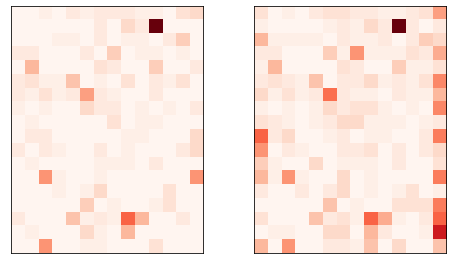

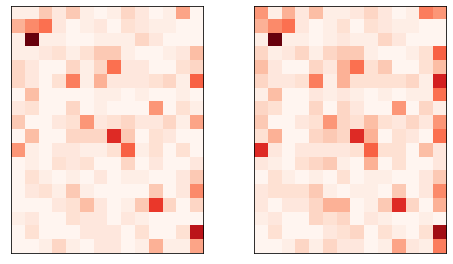

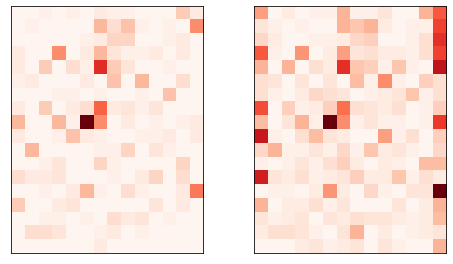

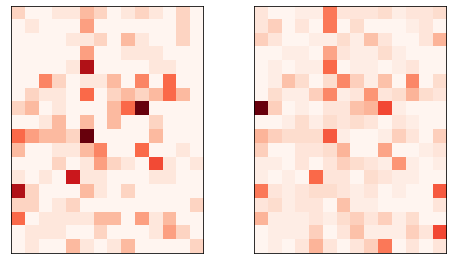

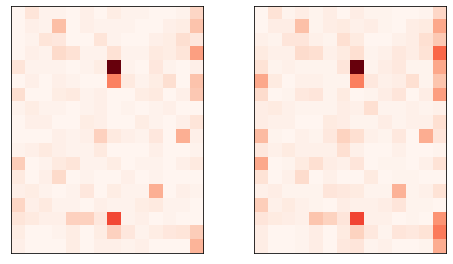

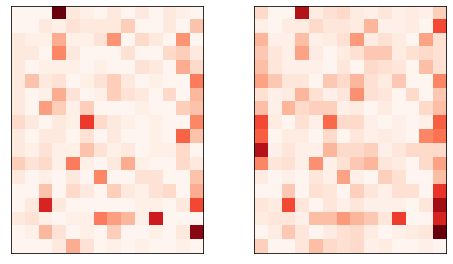

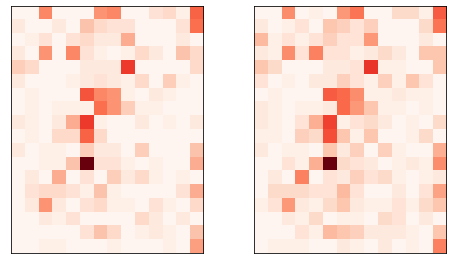

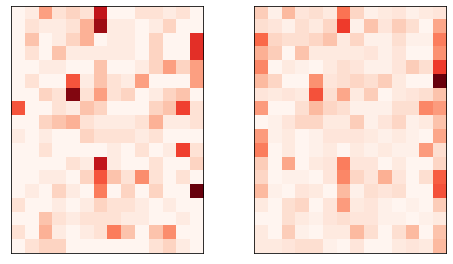

In [13]:
#Plot and compare backgrounds before and after the overlay
for i in range(110, 120):
    plt.figure(figsize = (8, 10))
    ax = plt.subplot(2, 2, 1)
    #plt.imshow(QCD[i,:,:,0].reshape(18, 14), cmap = 'Reds')
    #plt.imshow(SingleNu_E10[i,:,:,0].reshape(18, 14), cmap = 'Reds')
    plt.imshow(SingleNu_Pt2To20[i,:,:,0].reshape(18, 14), cmap = 'Reds')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 2, 2)
    #plt.imshow(QCD_zb[i,:,:,0].reshape(18, 14), cmap = 'Reds')
    #plt.imshow(SingleNu_E10_zb[i,:,:,0].reshape(18, 14), cmap = 'Reds')
    plt.imshow(SingleNu_Pt2To20_zb[i,:,:,0].reshape(18, 14), cmap = 'Reds')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    plt.show()

In [14]:
#Partition the whole training set into train/val/test sets
X = ZeroBias

train_ratio = 0.7
val_ratio = 0.2
test_ratio = 1 - train_ratio - val_ratio
X_train_val, X_test = train_test_split(X, test_size = test_ratio, random_state = 123)
X_train, X_val = train_test_split(X_train_val, test_size = val_ratio/(val_ratio + train_ratio), random_state = 123)

## Convolutional autoencoder

### Create model

In [15]:
encoder_input = tf.keras.Input(shape = (18, 14, 1))
encoding = layers.Conv2D(3, (3, 3), activation = 'softplus', strides = 1, padding = 'same')(encoder_input)
encoding = layers.MaxPooling2D((2, 2))(encoding)
encoding = layers.Conv2D(1, (3, 3), activation = 'softplus', strides = 1, padding = 'same')(encoding)

encoder_output = layers.Conv2D(1, (3, 3), activation = 'softplus', strides = 1, padding = 'same')(encoding)

encoder = tf.keras.models.Model(encoder_input, encoder_output)
encoder.summary()

Metal device set to: Apple M1
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 14, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 18, 14, 3)         30        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 7, 3)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 7, 1)           28        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 7, 1)           10        
Total params: 68
Trainable params: 68
Non-trainable params: 0
_________________________________________________________________


2022-04-08 22:36:48.208913: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-08 22:36:48.209351: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
decoding = layers.Conv2DTranspose(3, (3, 3), activation = 'softplus', strides = 1, padding = 'same')(encoder_output)
decoding = layers.UpSampling2D((2, 2))(decoding)
decoding = layers.Conv2DTranspose(5, (3, 3), activation = 'softplus', strides = 1, padding = 'same')(decoding)

decoder_output = layers.Conv2D(1, (3, 3), activation = 'softplus', strides = 1, padding = 'same')(decoding)

In [17]:
model = tf.keras.Model(encoder_input, decoder_output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 14, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 18, 14, 3)         30        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 7, 3)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 7, 1)           28        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 7, 1)           10        
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 9, 7, 3)           30        
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 18, 14, 3)         0   

In [18]:
model.compile(optimizer = 'adam', loss = "mse")

### Training

In [19]:
history = model.fit(X_train, X_train,
                    epochs = 50,
                    validation_data = (X_val, X_val),
                    batch_size = 512,
                    callbacks = [
                        tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, mode = "min")
                    ])

2022-04-08 22:36:57.210048: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-08 22:36:57.210342: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-08 22:36:57.401136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50
432/432 [==============================] - ETA: 0s - loss: 5.4452

2022-04-08 22:37:09.812262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


432/432 [==============================] - 14s 31ms/step - loss: 5.4452 - val_loss: 3.9918
Epoch 2/50
432/432 [==============================] - 13s 31ms/step - loss: 3.6655 - val_loss: 3.2689
Epoch 3/50
432/432 [==============================] - 15s 36ms/step - loss: 2.9895 - val_loss: 2.8184
Epoch 4/50
432/432 [==============================] - 14s 33ms/step - loss: 2.7385 - val_loss: 2.6521
Epoch 5/50
432/432 [==============================] - 14s 32ms/step - loss: 2.6064 - val_loss: 2.5577
Epoch 6/50
432/432 [==============================] - 15s 34ms/step - loss: 2.5268 - val_loss: 2.4855
Epoch 7/50
432/432 [==============================] - 16s 37ms/step - loss: 2.4603 - val_loss: 2.4190
Epoch 8/50
432/432 [==============================] - 14s 32ms/step - loss: 2.4025 - val_loss: 2.3726
Epoch 9/50
432/432 [==============================] - 13s 31ms/step - loss: 2.3562 - val_loss: 2.3257
Epoch 10/50
432/432 [==============================] - 14s 33ms/step - loss: 2.3126 - val_los

Text(0, 0.5, 'Loss')

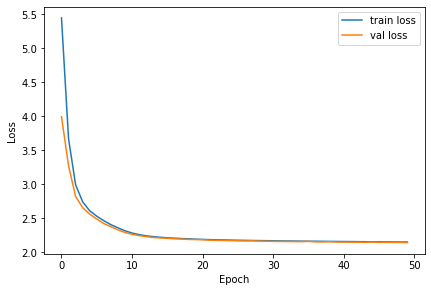

In [20]:
# plot loss vs epoch
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
#axes.set_yscale(value = "log")
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [21]:
X_train_predict = model.predict(X_train)
X_test_predict = model.predict(X_test)
signals_zb_predict = []
for i in range(len(signals_zb)):
    signals_zb_predict.append(model.predict(signals_zb[i]))

2022-04-08 22:58:55.113060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-08 22:59:49.718210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [23]:
QCD_zb_predict = model.predict(QCD_zb)
SingleNu_E10_zb_predict = model.predict(SingleNu_E10_zb)
SingleNu_Pt2To20_zb_predict = model.predict(SingleNu_Pt2To20_zb)

### Save model

In [24]:
model.save('saved_models/convAE_model/')

2022-04-08 23:24:39.254399: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_models/convAE_model/assets


In [25]:
savedmodel = tf.keras.models.load_model('saved_models/convAE_model')
savedmodel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 14, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 18, 14, 3)         30        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 7, 3)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 7, 1)           28        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 7, 1)           10        
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 9, 7, 3)           30        
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 18, 14, 3)         0   

## Evaluate performance of the trained model

### Compute and plot loss distributions

In [26]:
X_train_mse = np.mean((X_train_predict - X_train)**2, axis = (1, 2))
X_test_mse = np.mean((X_test_predict - X_test)**2, axis = (1, 2))

signals_zb_mse = []
for i in range(len(signals_zb)):
    signals_zb_mse.append(np.mean((signals_zb_predict[i] - signals_zb[i])**2, axis = (1, 2)))

In [27]:
QCD_zb_mse = np.mean((QCD_zb_predict - QCD_zb)**2, axis = (1, 2))
SingleNu_E10_zb_mse = np.mean((SingleNu_E10_zb_predict - SingleNu_E10_zb)**2, axis = (1, 2))
SingleNu_Pt2To20_zb_mse = np.mean((SingleNu_Pt2To20_zb_predict - SingleNu_Pt2To20_zb)**2, axis = (1, 2))

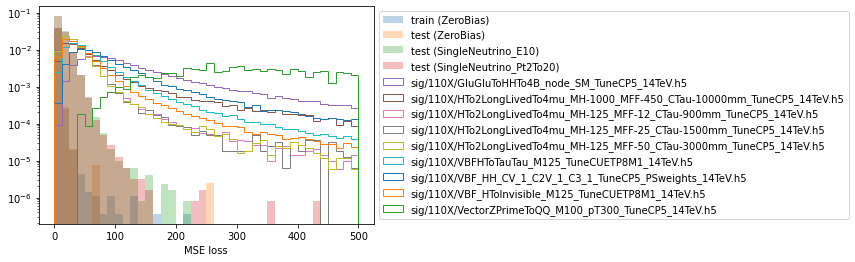

In [28]:
nbins = 40
rmin = 0
rmax = 500
plt.hist(X_train_mse, density = 1, bins = nbins, alpha = 0.3, label = 'train (ZeroBias)', range = (rmin, rmax), log = True)
plt.hist(X_test_mse, density = 1, bins = nbins, alpha = 0.3, label = 'test (ZeroBias)', range = (rmin, rmax))
#plt.hist(QCD_zb_mse, density = 1, bins = nbins, alpha = 0.3, label = 'test (QCD)', range = (rmin, rmax))
plt.hist(SingleNu_E10_zb_mse, density = 1, bins = nbins, alpha = 0.3, label = 'test (SingleNeutrino_E10)', range = (rmin, rmax))
plt.hist(SingleNu_Pt2To20_zb_mse, density = 1, bins = nbins, alpha = 0.3, label = 'test (SingleNeutrino_Pt2To20)', range = (rmin, rmax))
#for i in range(len(signals_zb)):
for i in range(0,9):
    plt.hist(signals_zb_mse[i], density = 1, bins = nbins, label = signal_files[i], histtype = 'step', range = (rmin, rmax))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("MSE loss")
#plt.xticks(np.arange(rmin, rmax, step = 0.0002))
plt.show()

### Plot and compare the original and reconstructed inputs

MSE loss = [1.1334585]


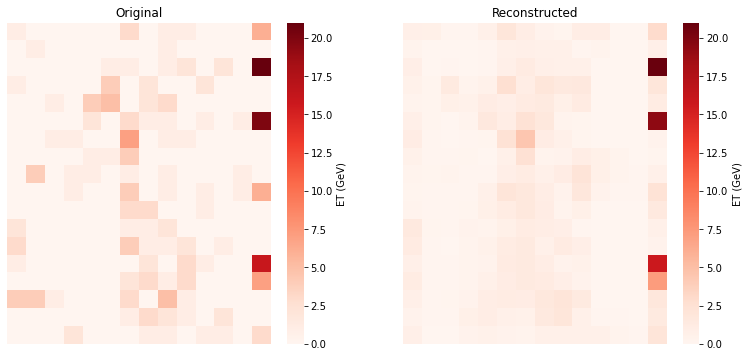

MSE loss = [1.725532]


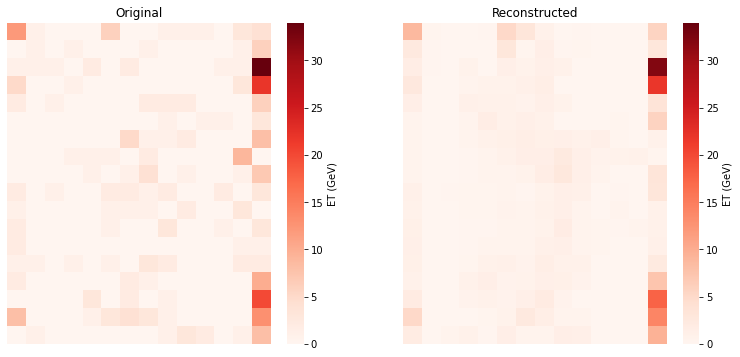

MSE loss = [0.6323464]


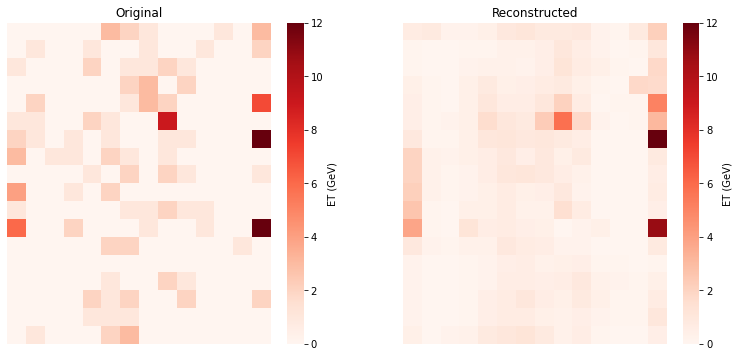

MSE loss = [0.17560895]


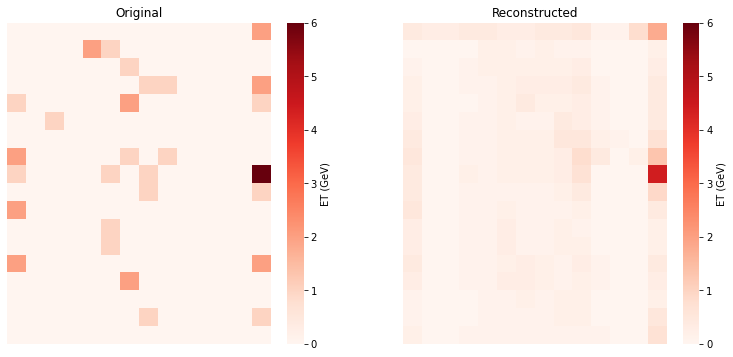

MSE loss = [0.28964037]


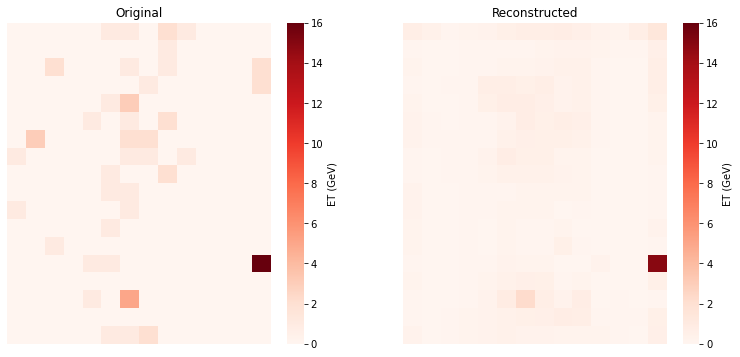

MSE loss = [4.694156]


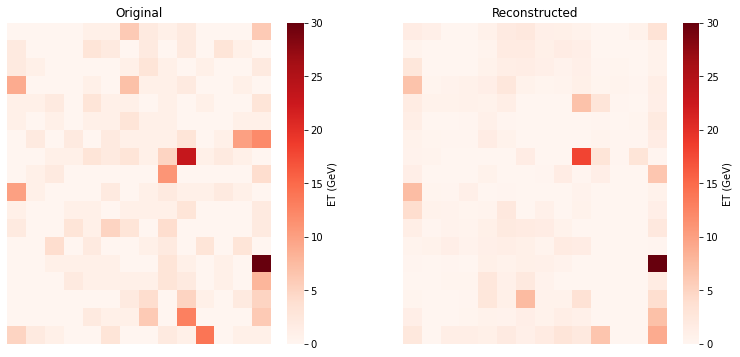

MSE loss = [5.010756]


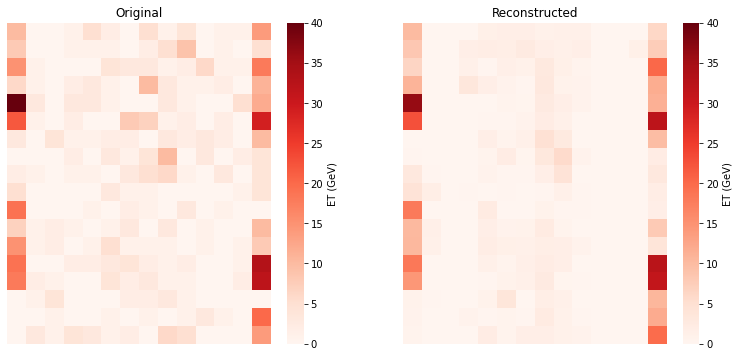

MSE loss = [1.8996394]


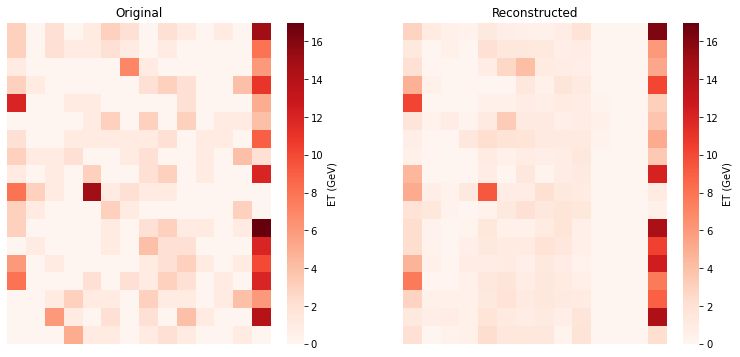

MSE loss = [1.0207089]


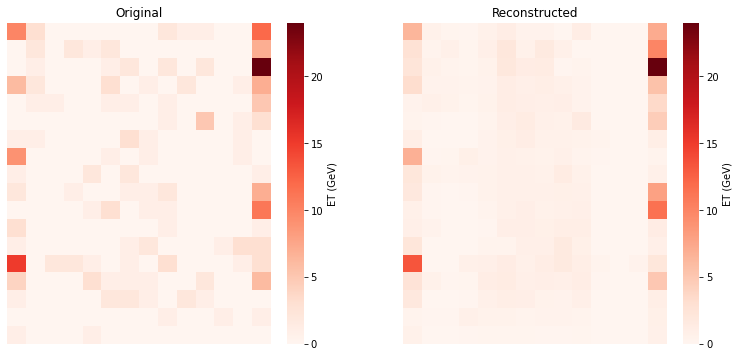

MSE loss = [1.1551516]


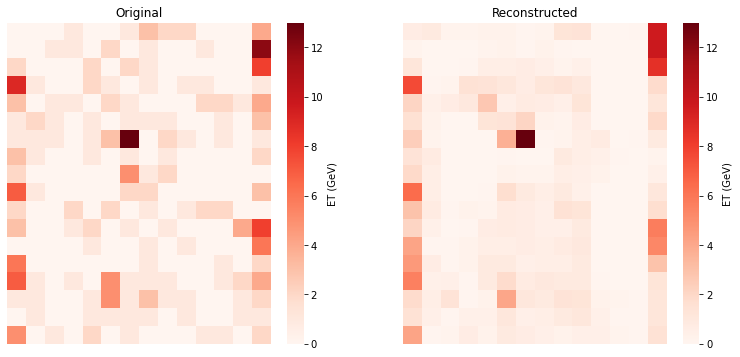

In [29]:
n = 10
#Original vs Reconstructed for ZB test
for i in range(140,150):
    fig, ax = plt.subplots(figsize = (13,13))
    print('MSE loss = ' + str(X_test_mse[i]))
    #print('MSE loss = ' + str(signals_zb_mse[n][i]))
    #print('MSE loss = ' + str(QCD_zb_mse[i]))
    #print('MSE loss = ' + str(SingleNu_E10_zb_mse[i]))
    #print('MSE loss = ' + str(SingleNu_Pt2To20_zb_mse[i]))
    ax = plt.subplot(2, 2, 1)
    ax = sns.heatmap(X_test[i,:,:,0].reshape(18, 14), vmin = 0, vmax = X_test[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(signals_zb[n][i,:,:,0].reshape(18, 14), vmin = 0, vmax = signals_zb[n][i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(QCD_zb[i,:,:,0].reshape(18, 14), vmin = 0, vmax = QCD_zb[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(SingleNu_E10_zb[i,:,:,0].reshape(18, 14), vmin = 0, vmax = SingleNu_E10_zb[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(SingleNu_Pt2To20_zb[i,:,:,0].reshape(18, 14), vmin = 0, vmax = SingleNu_Pt2To20_zb[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Original')
    
    ax = plt.subplot(2, 2, 2)
    ax = sns.heatmap(np.round(X_test_predict[i,:,:,0].reshape(18, 14),1), vmin = 0, vmax = X_test[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(np.round(signals_zb_predict[n][i,:,:,0].reshape(18, 14),1), vmin = 0, vmax = signals_zb[n][i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(np.round(QCD_zb_predict[i,:,:,0].reshape(18, 14),1), vmin = 0, vmax = QCD_zb[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(np.round(SingleNu_E10_zb_predict[i,:,:,0].reshape(18, 14),1), vmin = 0, vmax = SingleNu_E10_zb[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(np.round(SingleNu_Pt2To20_zb_predict[i,:,:,0].reshape(18, 14),1), vmin = 0, vmax = SingleNu_Pt2To20_zb[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Reconstructed')
    plt.show()

MSE loss = [1.1334585]


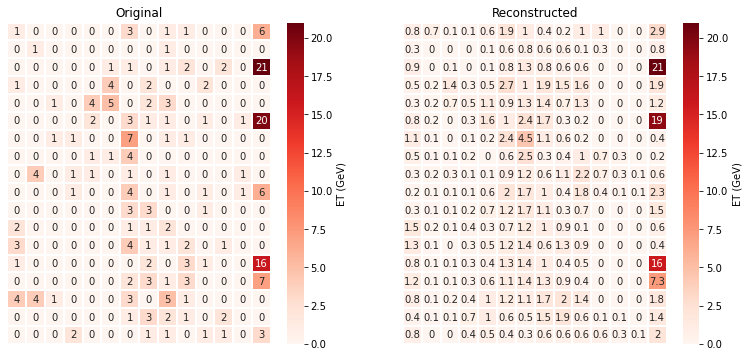

MSE loss = [1.725532]


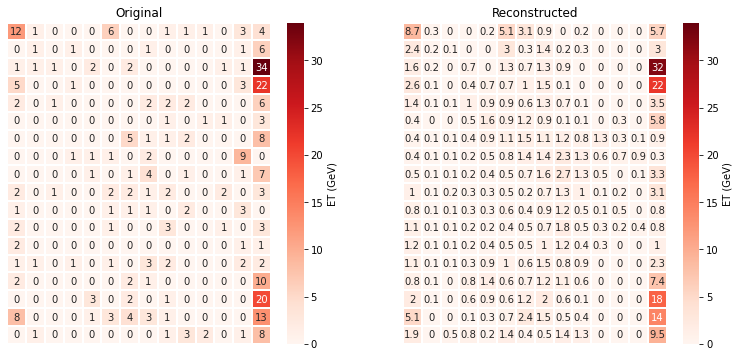

MSE loss = [0.6323464]


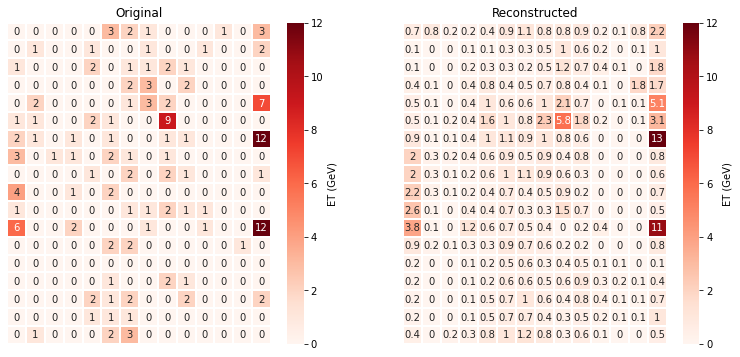

MSE loss = [0.17560895]


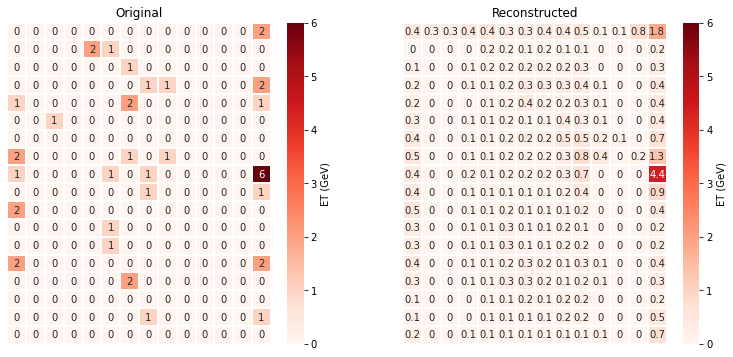

MSE loss = [0.28964037]


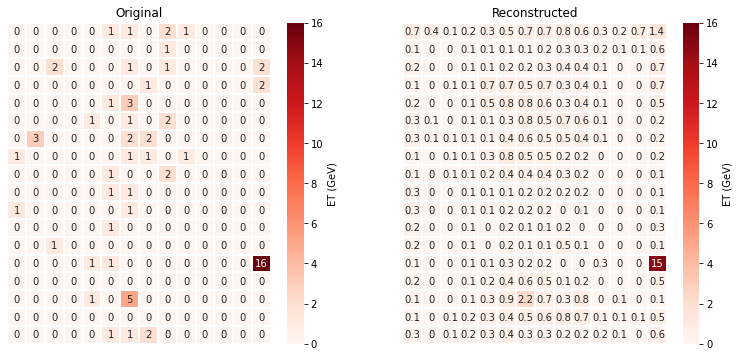

MSE loss = [4.694156]


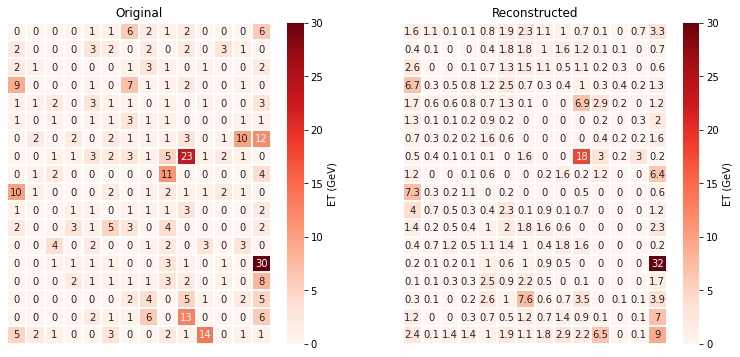

MSE loss = [5.010756]


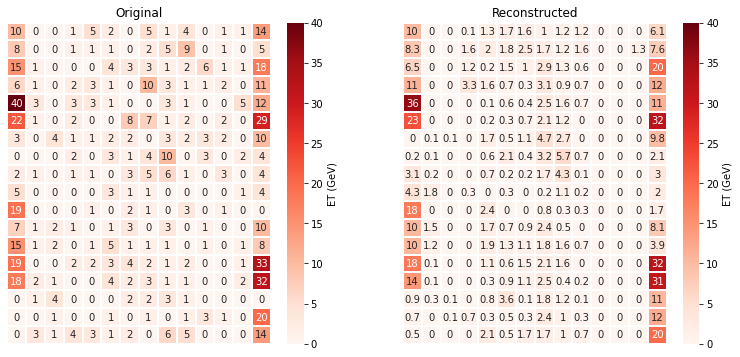

MSE loss = [1.8996394]


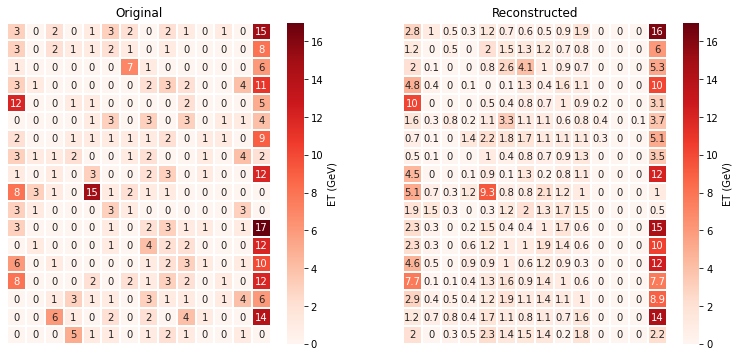

MSE loss = [1.0207089]


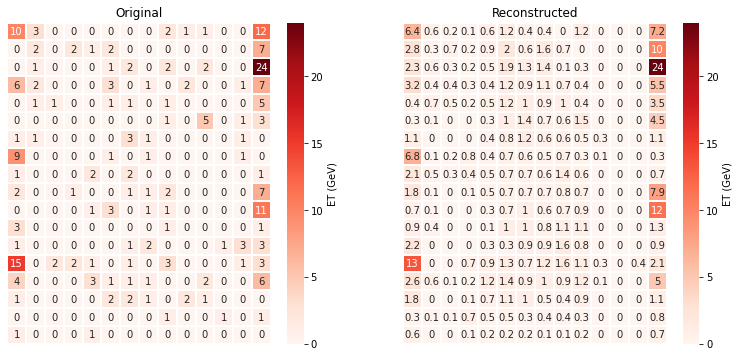

MSE loss = [1.1551516]


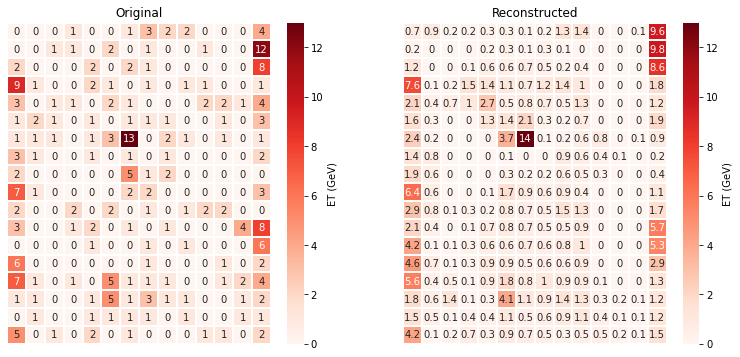

In [30]:
n = 10
#Original vs Reconstructed for ZB test
for i in range(140,150):
    fig, ax = plt.subplots(figsize = (13,13))
    print('MSE loss = ' + str(X_test_mse[i]))
    #print('MSE loss = ' + str(signals_zb_mse[n][i]))
    #print('MSE loss = ' + str(QCD_zb_mse[i]))
    #print('MSE loss = ' + str(SingleNu_E10_zb_mse[i]))
    #print('MSE loss = ' + str(SingleNu_Pt2To20_zb_mse[i]))
    ax = plt.subplot(2, 2, 1)
    ax = sns.heatmap(X_test[i,:,:,0].reshape(18, 14), vmin = 0, vmax = X_test[i,:,:,0].max(), annot = True, linewidths = 0.1, cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(signals_zb[n][i,:,:,0].reshape(18, 14), vmin = 0, vmax = signals_zb[n][i,:,:,0].max(), annot = True, linewidths = 0.1, cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(QCD_zb[i,:,:,0].reshape(18, 14), vmin = 0, vmax = QCD_zb[i,:,:,0].max(), annot = True, linewidths = 0.1, cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(SingleNu_E10_zb[i,:,:,0].reshape(18, 14), vmin = 0, vmax = SingleNu_E10_zb[i,:,:,0].max(), annot = True, linewidths = 0.1, cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(SingleNu_Pt2To20_zb[i,:,:,0].reshape(18, 14), vmin = 0, vmax = SingleNu_Pt2To20_zb[i,:,:,0].max(), annot = True, linewidths = 0.1, cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Original')
    
    ax = plt.subplot(2, 2, 2)
    ax = sns.heatmap(np.round(X_test_predict[i,:,:,0].reshape(18, 14),1), vmin = 0, vmax = X_test[i,:,:,0].max(), annot = True, linewidths = 0.1, cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(np.round(signals_zb_predict[n][i,:,:,0].reshape(18, 14),1), vmin = 0, vmax = signals_zb[n][i,:,:,0].max(), annot = True, linewidths = 0.1, cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(np.round(QCD_zb_predict[i,:,:,0].reshape(18, 14),1), vmin = 0, vmax = QCD_zb[i,:,:,0].max(), annot = True, linewidths = 0.1, cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(np.round(SingleNu_E10_zb_predict[i,:,:,0].reshape(18, 14),1), vmin = 0, vmax = SingleNu_E10_zb[i,:,:,0].max(), annot = True, linewidths = 0.1, cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(np.round(SingleNu_Pt2To20_zb_predict[i,:,:,0].reshape(18, 14),1), vmin = 0, vmax = SingleNu_Pt2To20_zb[i,:,:,0].max(), annot = True, linewidths = 0.1, cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Reconstructed')
    plt.show()

### Assign labels and concatenate testing sets for ROC plotting

In [31]:
#Benchmark model
#Just taking L2 norm of inputs
#No model, no learning!!
#Analogous to simply cutting on energies
BM_zb = np.mean(X_test**2, axis = (1, 2))
BM_QCD = np.mean(QCD_zb**2, axis = (1, 2))
BM_SingleNu_E10 = np.mean(SingleNu_E10_zb**2, axis = (1, 2))
BM_SingleNu_Pt2To20 = np.mean(SingleNu_Pt2To20_zb**2, axis = (1, 2))
BM_signals = []
for i in range(len(signals_zb)):
    BM_signals.append(np.mean(signals_zb[i]**2, axis = (1, 2)))

In [32]:
#Assign labels for various signals (y = 1) and backgrounds (y = 0)
Y_zb = np.zeros((X_test.shape[0], 1))
Y_QCD = np.zeros((QCD_zb.shape[0], 1))
Y_SingleNu_E10 = np.zeros((SingleNu_E10_zb.shape[0], 1))
Y_SingleNu_Pt2To20 = np.zeros((SingleNu_Pt2To20_zb.shape[0], 1))
Y_signals = []
for i in range(len(signals)):
    Y_signals.append(np.ones((signals_zb[i].shape[0], 1)))

#Concatenate datasets to make ROC curves, i.e. signals vs ZB/QCD/SingleNu
Y_true_vs_zb = []
Y_true_vs_QCD = []
Y_true_vs_SingleNu_E10 = []
Y_true_vs_SingleNu_Pt2To20 = []
Y_BM_vs_zb = []
Y_BM_vs_QCD = []
Y_BM_vs_SingleNu_E10 = []
Y_BM_vs_SingleNu_Pt2To20 = []
Y_model_vs_zb = []
Y_model_vs_QCD = []
Y_model_vs_SingleNu_E10 = []
Y_model_vs_SingleNu_Pt2To20 = []
for i in range(len(signals)):
    Y_true_vs_zb.append(np.concatenate((Y_signals[i], Y_zb)))
    Y_BM_vs_zb.append(np.concatenate((BM_signals[i], BM_zb)))
    Y_model_vs_zb.append(np.concatenate((signals_zb_mse[i], X_test_mse)))
    
    Y_true_vs_QCD.append(np.concatenate((Y_signals[i], Y_QCD)))
    Y_BM_vs_QCD.append(np.concatenate((BM_signals[i], BM_QCD)))
    Y_model_vs_QCD.append(np.concatenate((signals_zb_mse[i], QCD_zb_mse)))
    
    Y_true_vs_SingleNu_E10.append(np.concatenate((Y_signals[i], Y_SingleNu_E10)))
    Y_BM_vs_SingleNu_E10.append(np.concatenate((BM_signals[i], BM_SingleNu_E10)))
    Y_model_vs_SingleNu_E10.append(np.concatenate((signals_zb_mse[i], SingleNu_E10_zb_mse)))
    
    Y_true_vs_SingleNu_Pt2To20.append(np.concatenate((Y_signals[i], Y_SingleNu_Pt2To20)))
    Y_BM_vs_SingleNu_Pt2To20.append(np.concatenate((BM_signals[i], BM_SingleNu_Pt2To20)))
    Y_model_vs_SingleNu_Pt2To20.append(np.concatenate((signals_zb_mse[i], SingleNu_Pt2To20_zb_mse)))

### Plot benchmark (only L2 norm on inputs, no model) ROC (signals vs ZB)

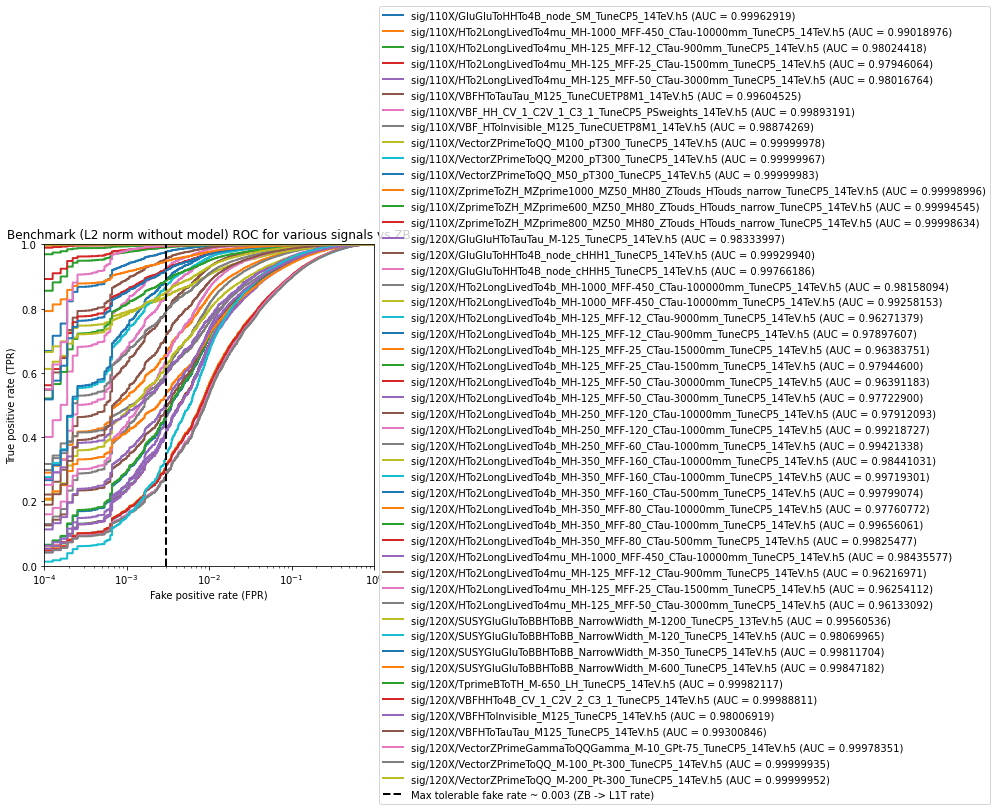

In [35]:
plt.figure(figsize = (13, 13))
axes = plt.subplot(2, 2, 1)
fpr_BM_vs_zb = []
tpr_BM_vs_zb = []
thresholds_BM_vs_zb = []
roc_auc_BM_vs_zb = []
for i in range(len(signals)):
    fpr_BM_vs_zb.append(np.empty((Y_true_vs_zb[i].shape[0],1)))
    tpr_BM_vs_zb.append(np.empty((Y_true_vs_zb[i].shape[0],1)))
    thresholds_BM_vs_zb.append(np.empty((Y_true_vs_zb[i].shape[0],1)))
    roc_auc_BM_vs_zb.append(np.empty((Y_true_vs_zb[i].shape[0],1)))
    fpr_BM_vs_zb[i], tpr_BM_vs_zb[i], thresholds_BM_vs_zb[i] = roc_curve(Y_true_vs_zb[i], Y_BM_vs_zb[i])
    roc_auc_BM_vs_zb[i] = auc(fpr_BM_vs_zb[i], tpr_BM_vs_zb[i])
    axes.plot(fpr_BM_vs_zb[i], tpr_BM_vs_zb[i], lw = 2, label = signal_files[i] + ' (AUC = %.8f)' % (roc_auc_BM_vs_zb[i]))
#axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.plot([0.003, 0.003], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'Max tolerable fake rate ~ 0.003 (ZB -> L1T rate)')
axes.set_xlim([0.0001, 1.0])
#axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
#axes.set_ylim([0.9, 1.0])
axes.set_xscale(value = "log")
#axes.set_yscale(value = "log")
axes.set_xlabel('Fake positive rate (FPR)')
axes.set_ylabel('True positive rate (TPR)')
axes.set_title('Benchmark (L2 norm without model) ROC for signals vs ZB')
axes.legend(loc='center left', bbox_to_anchor = (1, 0.5))
plt.show()

### Plot ROC (signals vs ZB)

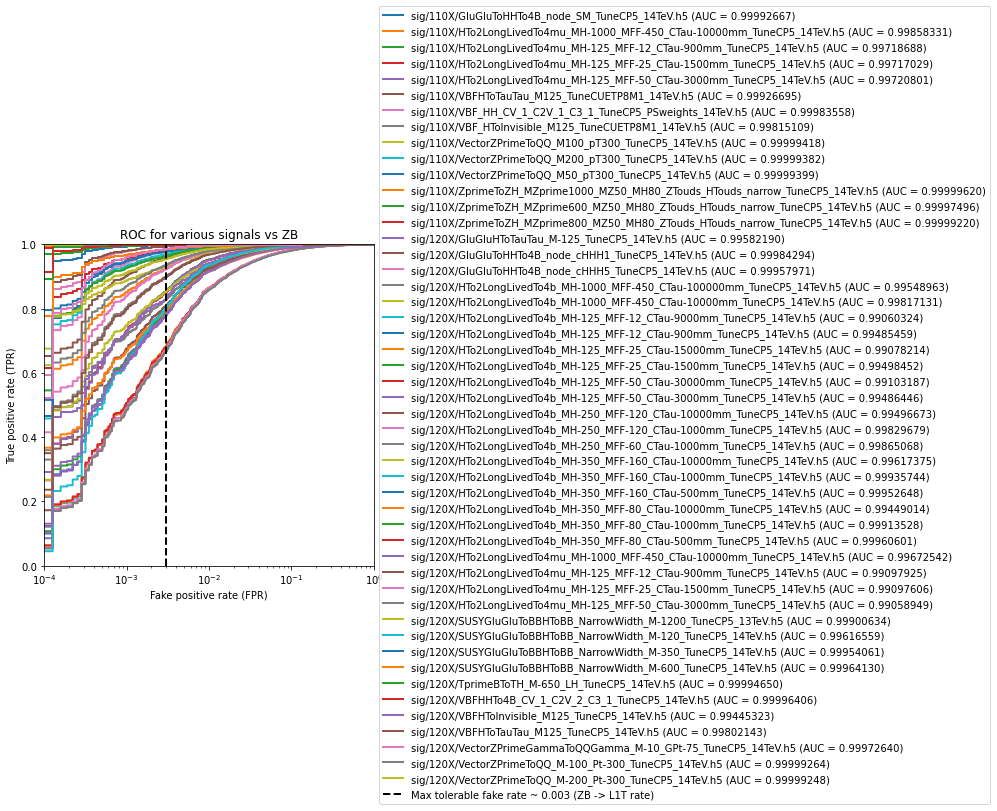

In [34]:
plt.figure(figsize = (13, 13))
axes = plt.subplot(2, 2, 1)
fpr_vs_zb = []
tpr_vs_zb = []
thresholds_vs_zb = []
roc_auc_vs_zb = []
for i in range(len(signals)):
    fpr_vs_zb.append(np.empty((Y_true_vs_zb[i].shape[0],1)))
    tpr_vs_zb.append(np.empty((Y_true_vs_zb[i].shape[0],1)))
    thresholds_vs_zb.append(np.empty((Y_true_vs_zb[i].shape[0],1)))
    roc_auc_vs_zb.append(np.empty((Y_true_vs_zb[i].shape[0],1)))
    fpr_vs_zb[i], tpr_vs_zb[i], thresholds_vs_zb[i] = roc_curve(Y_true_vs_zb[i], Y_model_vs_zb[i])
    roc_auc_vs_zb[i] = auc(fpr_vs_zb[i], tpr_vs_zb[i])
    axes.plot(fpr_vs_zb[i], tpr_vs_zb[i], lw = 2, label = signal_files[i] + ' (AUC = %.8f)' % (roc_auc_vs_zb[i]))
#axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.plot([0.003, 0.003], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'Max tolerable fake rate ~ 0.003 (ZB -> L1T rate)')
axes.set_xlim([0.0001, 1.0])
#axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
#axes.set_ylim([0.9, 1.0])
axes.set_xscale(value = "log")
#axes.set_yscale(value = "log")
axes.set_xlabel('Fake positive rate (FPR)')
axes.set_ylabel('True positive rate (TPR)')
axes.set_title('ROC for signals vs ZB')
axes.legend(loc='center left', bbox_to_anchor = (1, 0.5))
plt.show()

### Plot ROC (signals vs QCD)

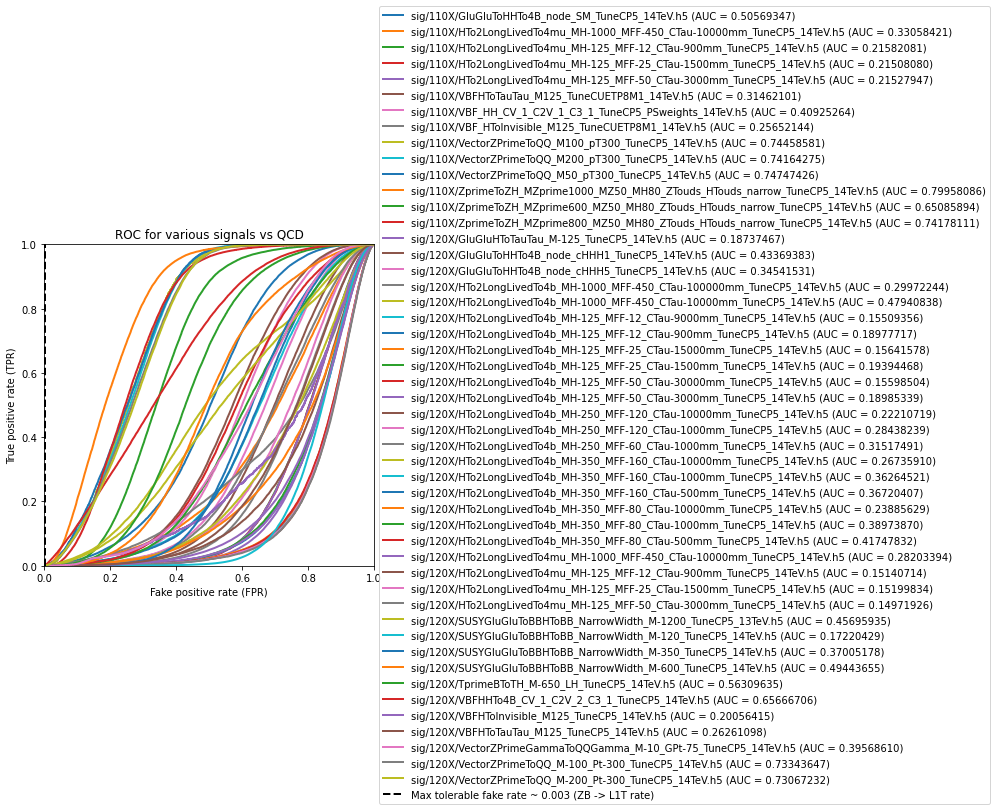

In [37]:
plt.figure(figsize = (13, 13))
axes = plt.subplot(2, 2, 1)
fpr_vs_QCD = []
tpr_vs_QCD = []
thresholds_vs_QCD = []
roc_auc_vs_QCD = []
for i in range(len(signals)):
    fpr_vs_QCD.append(np.empty((Y_true_vs_QCD[i].shape[0],1)))
    tpr_vs_QCD.append(np.empty((Y_true_vs_QCD[i].shape[0],1)))
    thresholds_vs_QCD.append(np.empty((Y_true_vs_QCD[i].shape[0],1)))
    roc_auc_vs_QCD.append(np.empty((Y_true_vs_QCD[i].shape[0],1)))
    fpr_vs_QCD[i], tpr_vs_QCD[i], thresholds_vs_QCD[i] = roc_curve(Y_true_vs_QCD[i], Y_model_vs_QCD[i])
    roc_auc_vs_QCD[i] = auc(fpr_vs_QCD[i], tpr_vs_QCD[i])
    axes.plot(fpr_vs_QCD[i], tpr_vs_QCD[i], lw = 2, label = signal_files[i] + ' (AUC = %.8f)' % (roc_auc_vs_QCD[i]))
#axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.plot([0.003, 0.003], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'Max tolerable fake rate ~ 0.003 (ZB -> L1T rate)')
#axes.set_xlim([0.0001, 1.0])
axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
#axes.set_ylim([0.9, 1.0])
#axes.set_xscale(value = "log")
#axes.set_yscale(value = "log")
axes.set_xlabel('Fake positive rate (FPR)')
axes.set_ylabel('True positive rate (TPR)')
axes.set_title('ROC for signals vs QCD')
axes.legend(loc='center left', bbox_to_anchor = (1, 0.5))
plt.show()

### Plot ROC (signals vs SingleNu_E10)

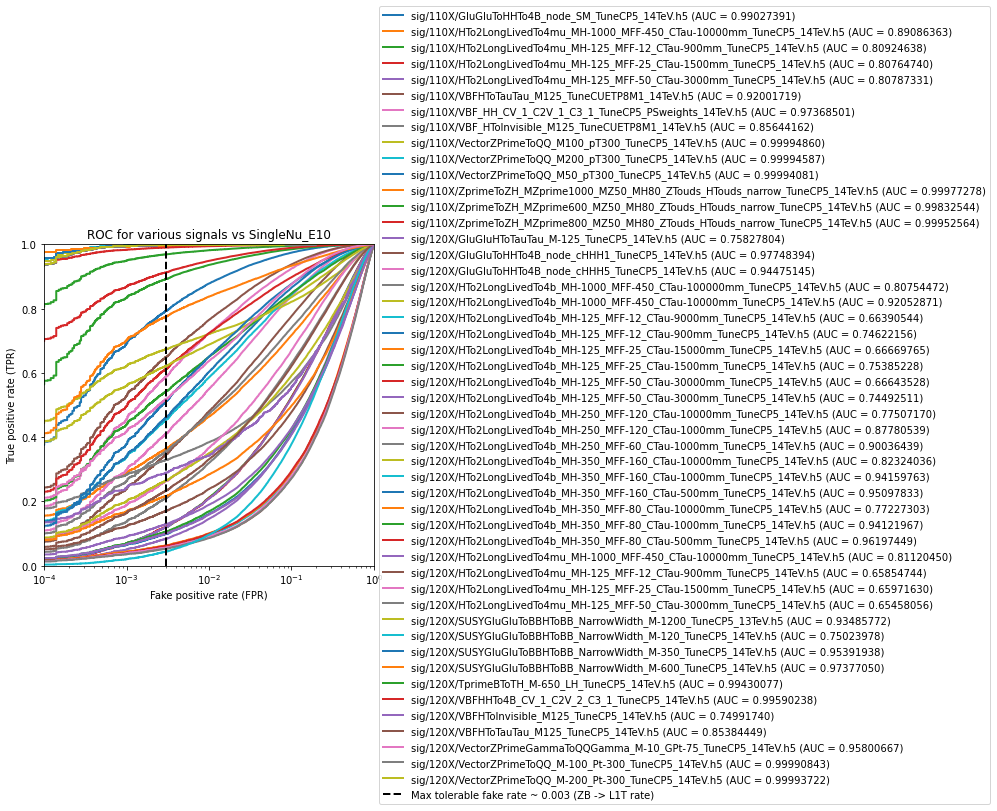

In [38]:
plt.figure(figsize = (13, 13))
axes = plt.subplot(2, 2, 1)
fpr_vs_SingleNu_E10 = []
tpr_vs_SingleNu_E10 = []
thresholds_vs_SingleNu_E10 = []
roc_auc_vs_SingleNu_E10 = []
for i in range(len(signals)):
    fpr_vs_SingleNu_E10.append(np.empty((Y_true_vs_SingleNu_E10[i].shape[0],1)))
    tpr_vs_SingleNu_E10.append(np.empty((Y_true_vs_SingleNu_E10[i].shape[0],1)))
    thresholds_vs_SingleNu_E10.append(np.empty((Y_true_vs_SingleNu_E10[i].shape[0],1)))
    roc_auc_vs_SingleNu_E10.append(np.empty((Y_true_vs_SingleNu_E10[i].shape[0],1)))
    fpr_vs_SingleNu_E10[i], tpr_vs_SingleNu_E10[i], thresholds_vs_SingleNu_E10[i] = roc_curve(Y_true_vs_SingleNu_E10[i], Y_model_vs_SingleNu_E10[i])
    roc_auc_vs_SingleNu_E10[i] = auc(fpr_vs_SingleNu_E10[i], tpr_vs_SingleNu_E10[i])
    axes.plot(fpr_vs_SingleNu_E10[i], tpr_vs_SingleNu_E10[i], lw = 2, label = signal_files[i] + ' (AUC = %.8f)' % (roc_auc_vs_SingleNu_E10[i]))
#axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.plot([0.003, 0.003], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'Max tolerable fake rate ~ 0.003 (ZB -> L1T rate)')
axes.set_xlim([0.0001, 1.0])
#axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
#axes.set_ylim([0.9, 1.0])
axes.set_xscale(value = "log")
#axes.set_yscale(value = "log")
axes.set_xlabel('Fake positive rate (FPR)')
axes.set_ylabel('True positive rate (TPR)')
axes.set_title('ROC for signals vs SingleNu_E10')
axes.legend(loc='center left', bbox_to_anchor = (1, 0.5))
plt.show()

### Plot ROC (signals vs SingleNu_Pt2To20)

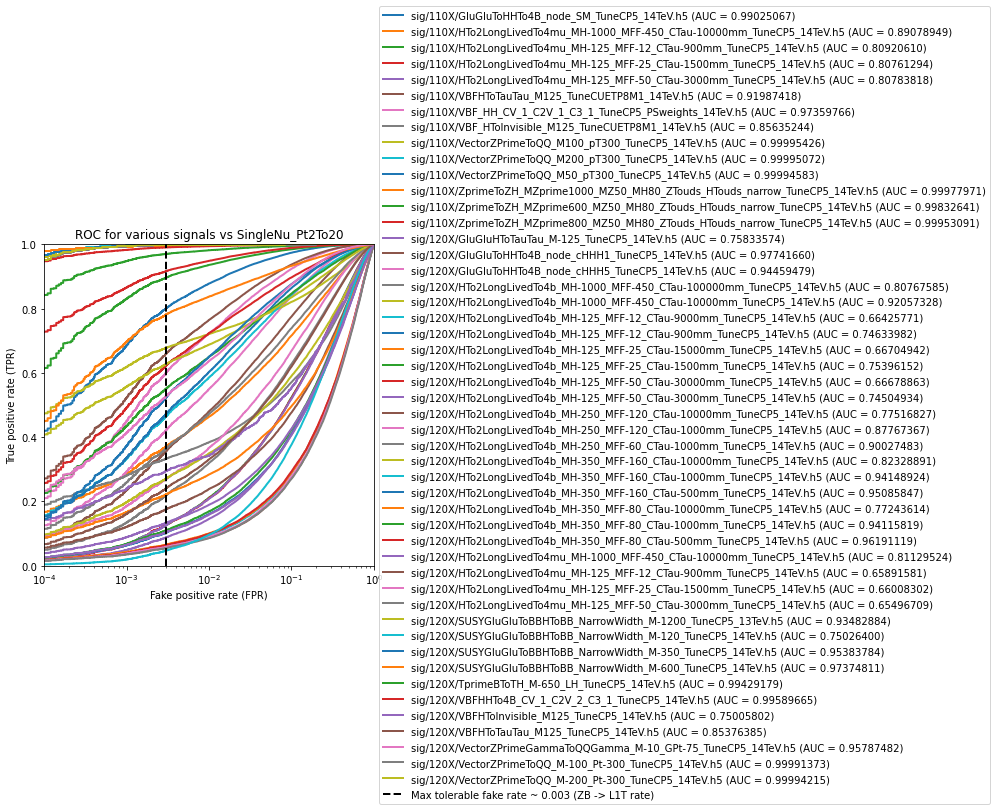

In [39]:
plt.figure(figsize = (13, 13))
axes = plt.subplot(2, 2, 1)
fpr_vs_SingleNu_Pt2To20 = []
tpr_vs_SingleNu_Pt2To20 = []
thresholds_vs_SingleNu_Pt2To20 = []
roc_auc_vs_SingleNu_Pt2To20 = []
for i in range(len(signals)):
    fpr_vs_SingleNu_Pt2To20.append(np.empty((Y_true_vs_SingleNu_Pt2To20[i].shape[0],1)))
    tpr_vs_SingleNu_Pt2To20.append(np.empty((Y_true_vs_SingleNu_Pt2To20[i].shape[0],1)))
    thresholds_vs_SingleNu_Pt2To20.append(np.empty((Y_true_vs_SingleNu_Pt2To20[i].shape[0],1)))
    roc_auc_vs_SingleNu_Pt2To20.append(np.empty((Y_true_vs_SingleNu_Pt2To20[i].shape[0],1)))
    fpr_vs_SingleNu_Pt2To20[i], tpr_vs_SingleNu_Pt2To20[i], thresholds_vs_SingleNu_Pt2To20[i] = roc_curve(Y_true_vs_SingleNu_Pt2To20[i], Y_model_vs_SingleNu_Pt2To20[i])
    roc_auc_vs_SingleNu_Pt2To20[i] = auc(fpr_vs_SingleNu_Pt2To20[i], tpr_vs_SingleNu_Pt2To20[i])
    axes.plot(fpr_vs_SingleNu_Pt2To20[i], tpr_vs_SingleNu_Pt2To20[i], lw = 2, label = signal_files[i] + ' (AUC = %.8f)' % (roc_auc_vs_SingleNu_Pt2To20[i]))
#axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.plot([0.003, 0.003], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'Max tolerable fake rate ~ 0.003 (ZB -> L1T rate)')
axes.set_xlim([0.0001, 1.0])
#axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
#axes.set_ylim([0.9, 1.0])
axes.set_xscale(value = "log")
#axes.set_yscale(value = "log")
axes.set_xlabel('Fake positive rate (FPR)')
axes.set_ylabel('True positive rate (TPR)')
axes.set_title('ROC for signals vs SingleNu_Pt2To20')
axes.legend(loc='center left', bbox_to_anchor = (1, 0.5))
plt.show()

### Tabulate TPR at fixed FPR = 0.003 (benchmark, model, change)

In [44]:
table_tpr_BM_vs_zb = []
table_tpr_model_vs_zb = []
table_change_vs_zb = []
for i in range(len(fpr_BM_vs_zb)):
    for j in range(len(fpr_BM_vs_zb[i])):
        if fpr_BM_vs_zb[i][j] > 0.003:
            table_tpr_BM_vs_zb.append(tpr_BM_vs_zb[i][j] * 100)
            break
    for j in range(len(fpr_vs_zb[i])):
        if fpr_vs_zb[i][j] > 0.003:
            table_tpr_model_vs_zb.append(tpr_vs_zb[i][j] * 100)
            break
for i in range(len(signals)):
    table_change_vs_zb.append(table_tpr_model_vs_zb[i] - table_tpr_BM_vs_zb[i])

In [57]:
table_tpr = pd.DataFrame({'Benchmark TPR at FPR = 0.3%': table_tpr_BM_vs_zb,
                          'Model TPR at FPR = 0.3%': table_tpr_model_vs_zb,
                          'Increase in TPR at FPR = 0.3%': table_change_vs_zb},
                        index = signal_files)
table_tpr = table_tpr.sort_values(by = 'Increase in TPR at FPR = 0.3%', ascending = False)
pd.set_option('display.max_colwidth', None)
table_tpr

Benchmark TPR at FPR = 0.3%  \
sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-120_TuneCP5_14TeV.h5                                    33.447600   
sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5                             40.677500   
sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-12_CTau-900mm_TuneCP5_14TeV.h5                              40.957500   
sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-25_CTau-1500mm_TuneCP5_14TeV.h5                             40.969231   
sig/120X/HTo2LongLivedTo4mu_MH-125_MFF-25_CTau-1500mm_TuneCP5_14TeV.h5                             27.884895   
sig/120X/HTo2LongLivedTo4mu_MH-125_MFF-12_CTau-900mm_TuneCP5_14TeV.h5                              27.880656   
sig/120X/HTo2LongLivedTo4mu_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5                             27.632970   
sig/120X/HTo2LongLivedTo4b_MH-125_MFF-25_CTau-15000mm_TuneCP5_14TeV.h5                             30.707838   
sig/120X/HTo2LongLivedTo4b_MH-125_MFF-50_CTau-30000mm_TuneCP5_14TeV.h5                             30.353796   
sig/120X/HTo2LongLivedTo4b_MH-125_MFF-12_CTau-9000mm_TuneCP5_14TeV.h5                              30.440202   
sig/120X/HTo2LongLivedTo4b_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5                              41.502331   
sig/120X/GluGluHToTauTau_M-125_TuneCP5_14TeV.h5                                                    45.112000   
sig/120X/HTo2LongLivedTo4b_MH-125_MFF-25_CTau-1500mm_TuneCP5_14TeV.h5                              46.472500   
sig/120X/HTo2LongLivedTo4b_MH-250_MFF-120_CTau-10000mm_TuneCP5_14TeV.h5                            48.427842   
sig/120X/HTo2LongLivedTo4b_MH-125_MFF-12_CTau-900mm_TuneCP5_14TeV.h5                               46.232603   
sig/110X/VBF_HToInvisible_M125_TuneCUETP8M1_14TeV.h5                                               59.836082   
sig/120X/HTo2LongLivedTo4b_MH-250_MFF-120_CTau-1000mm_TuneCP5_14TeV.h5                             63.764956   
sig/120X/VBFHToInvisible_M125_TuneCP5_14TeV.h5                                                     50.408115   
sig/110X/HTo2LongLivedTo4mu_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5                          65.915535   
sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-10000mm_TuneCP5_14TeV.h5                             53.092500   
sig/120X/HTo2LongLivedTo4mu_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5                          58.591549   
sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-10000mm_TuneCP5_14TeV.h5                            61.706871   
sig/120X/HTo2LongLivedTo4b_MH-1000_MFF-450_CTau-100000mm_TuneCP5_14TeV.h5                          59.316778   
sig/120X/VBFHToTauTau_M125_TuneCP5_14TeV.h5                                                        71.041692   
sig/110X/VBFHToTauTau_M125_TuneCUETP8M1_14TeV.h5                                                   78.850667   
sig/120X/HTo2LongLivedTo4b_MH-250_MFF-60_CTau-1000mm_TuneCP5_14TeV.h5                              78.854929   
sig/120X/GluGluToHHTo4B_node_cHHH5_TuneCP5_14TeV.h5                                                83.920000   
sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-1200_TuneCP5_13TeV.h5                                   85.020224   
sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-1000mm_TuneCP5_14TeV.h5                             86.736656   
sig/120X/HTo2LongLivedTo4b_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5                           83.681381   
sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-500mm_TuneCP5_14TeV.h5                              88.585762   
sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-1000mm_TuneCP5_14TeV.h5                              88.601192   
sig/110X/VBF_HH_CV_1_C2V_1_C3_1_TuneCP5_PSweights_14TeV.h5                                         92.440000   
sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-350_TuneCP5_14TeV.h5                                    91.712800   
sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-500mm_TuneCP5_14TeV.h5                               92.203617   
sig/120X/GluGluToHHTo4B_node_cHHH1_TuneCP5_14TeV.

### Plot ROC, split in TPR ranges at FPR = 0.003

In [40]:
#Split ROC by efficiency range
sig_idx_eff_0to50 = []
sig_idx_eff_50to60 = []
sig_idx_eff_60to70 = []
sig_idx_eff_70to80 = []
sig_idx_eff_80to90 = []
sig_idx_eff_90to95 = []
sig_idx_eff_95to99 = []
sig_idx_eff_99to100 = []

for i in range(len(fpr_vs_zb)):
    for j in range(len(fpr_vs_zb[i])):
        if fpr_vs_zb[i][j] > 0.003:
            if tpr_vs_zb[i][j] > 0.99:
                sig_idx_eff_99to100.append(i)
            elif tpr_vs_zb[i][j] > 0.95:
                sig_idx_eff_95to99.append(i)
            elif tpr_vs_zb[i][j] > 0.9:
                sig_idx_eff_90to95.append(i)
            elif tpr_vs_zb[i][j] > 0.8:
                sig_idx_eff_80to90.append(i)
            elif tpr_vs_zb[i][j] > 0.7:
                sig_idx_eff_70to80.append(i)
            elif tpr_vs_zb[i][j] > 0.6:
                sig_idx_eff_60to70.append(i)
            elif tpr_vs_zb[i][j] > 0.5:
                sig_idx_eff_50to60.append(i)
            else:
                sig_idx_eff_0to50.append(i)
            break
sig_idx_eff_all = []
sig_idx_eff_all.append(sig_idx_eff_0to50)
sig_idx_eff_all.append(sig_idx_eff_50to60)
sig_idx_eff_all.append(sig_idx_eff_60to70)
sig_idx_eff_all.append(sig_idx_eff_70to80)
sig_idx_eff_all.append(sig_idx_eff_80to90)
sig_idx_eff_all.append(sig_idx_eff_90to95)
sig_idx_eff_all.append(sig_idx_eff_95to99)
sig_idx_eff_all.append(sig_idx_eff_99to100)

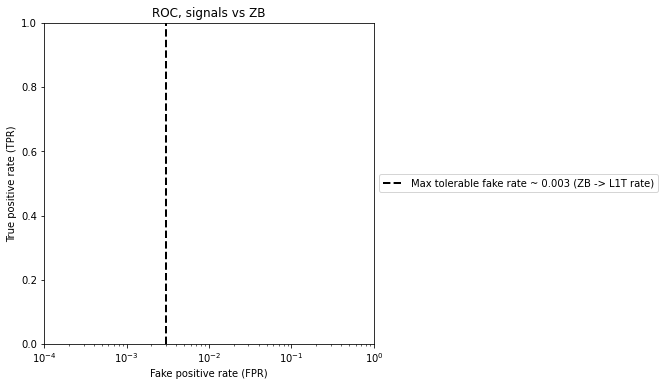

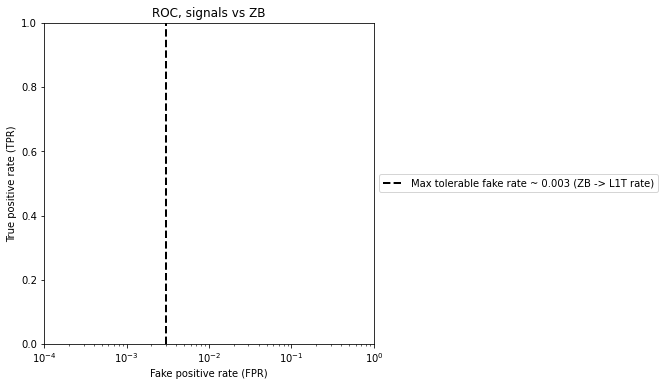

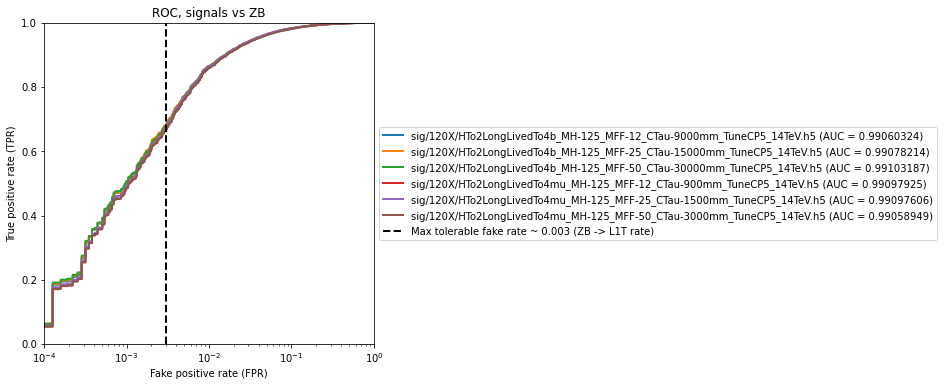

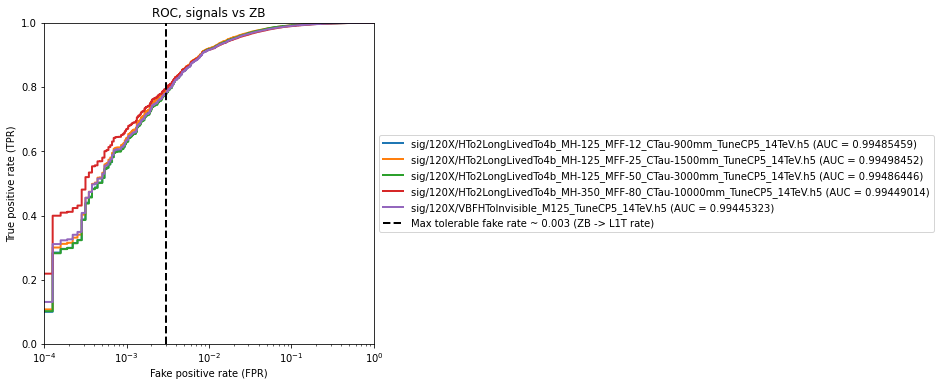

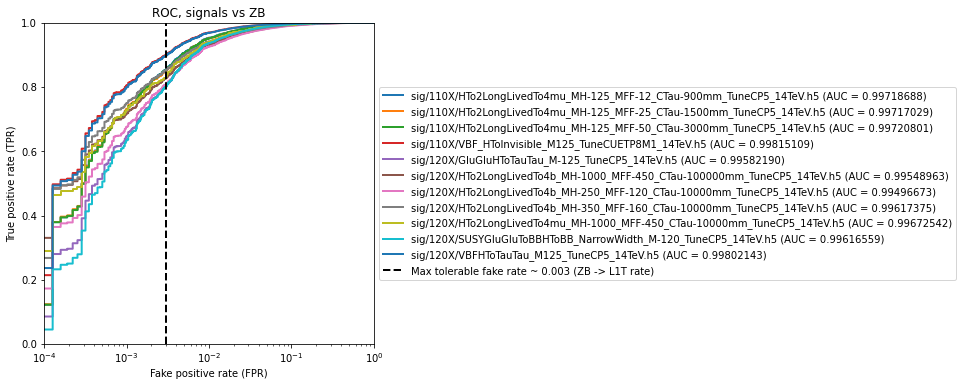

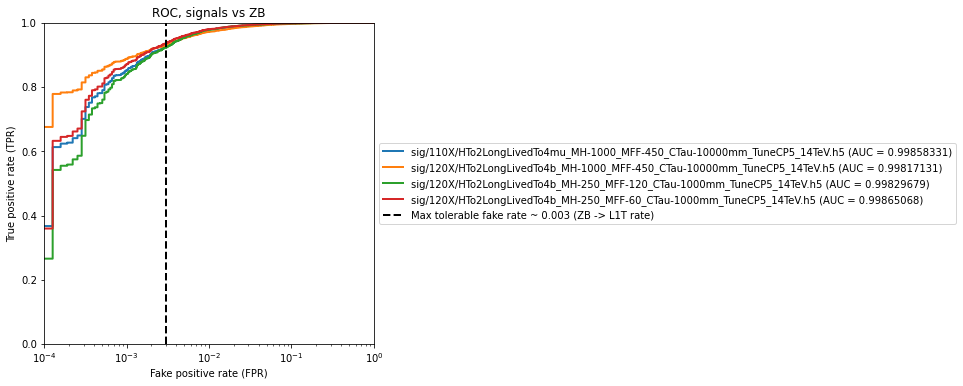

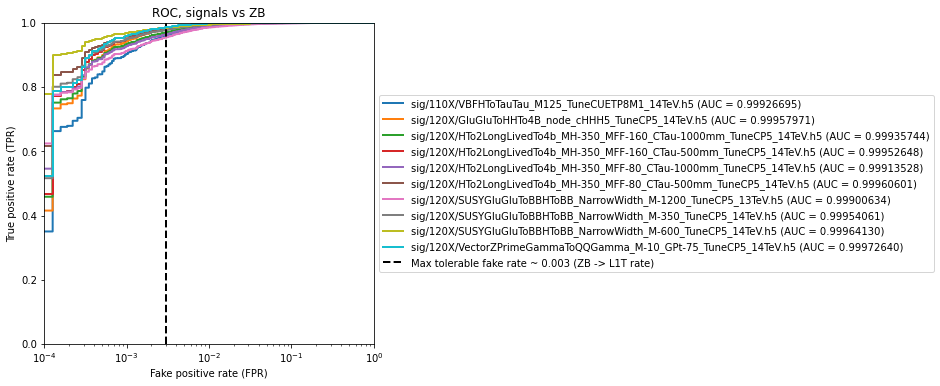

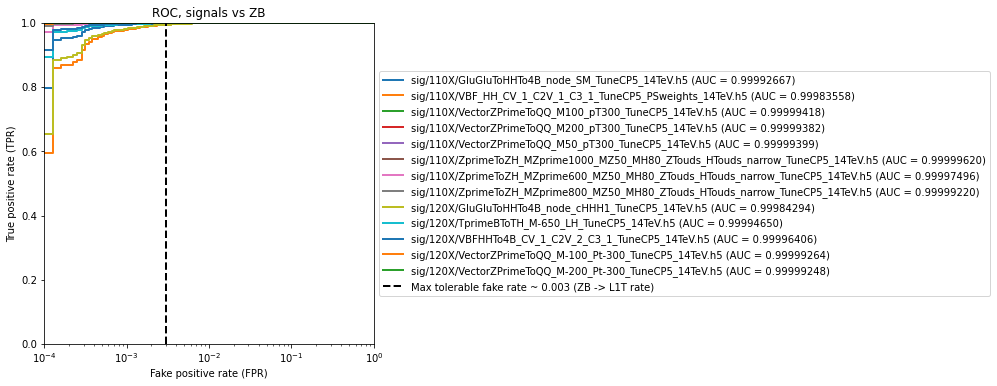

In [41]:
# Plot ROC by efficiency range
for i in range(len(sig_idx_eff_all)):
    plt.figure(figsize = (13, 13))
    axes = plt.subplot(2, 2, 1)
    for j in range(len(sig_idx_eff_all[i])):
        axes.plot(fpr_vs_zb[sig_idx_eff_all[i][j]], tpr_vs_zb[sig_idx_eff_all[i][j]], lw = 2, label = signal_files[sig_idx_eff_all[i][j]] + ' (AUC = %.8f)' % (roc_auc_vs_zb[sig_idx_eff_all[i][j]]))
    #axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
    axes.plot([0.003, 0.003], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'Max tolerable fake rate ~ 0.003 (ZB -> L1T rate)')
    axes.set_xlim([0.0001, 1.0])
    #axes.set_xlim([0, 1.0])
    axes.set_ylim([0, 1.0])
    #axes.set_ylim([0.99, 1.0])
    axes.set_xscale(value = "log")
    #axes.set_yscale(value = "log")
    axes.set_xlabel('Fake positive rate (FPR)')
    axes.set_ylabel('True positive rate (TPR)')
    axes.set_title('ROC for signals vs ZB')
    axes.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
    plt.show()